# KNN with DTW for pattern recognition and price (slope) prediction

Based off the paper 

http://www.journal.bonfring.org/papers/dm/volume3/BIJ-4658.pdf

and the ipynb

https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb


### Ingest data

In [180]:
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [181]:
data_dir = "../data/"
data_filename = os.listdir(data_dir)[0] # TODO: change data source to be minute-ly data not daily
data_path = data_dir + data_filename

data = pd.read_csv(data_path)
# Convert date string to datetime pandas Timestamp object
data.date = pd.to_datetime(data.date)

In [231]:
# Check out the data
print data.head(n=10)
print data.shape
data = data.sort_values(by="date")

           date    close          volume    open   high    low
1646 2012-05-18  38.2318  579377500.0000  42.000  45.00  38.00
1645 2012-05-21  34.0300  167943600.0000  36.530  36.66  33.00
1644 2012-05-22  31.0000  101667700.0000  32.610  33.59  30.94
1643 2012-05-23  32.0000   73541150.0000  31.370  32.50  31.36
1642 2012-05-24  33.0300   50208760.0000  32.950  33.21  31.77
1641 2012-05-25  31.9100   37101630.0000  32.900  32.95  31.11
1640 2012-05-29  28.8400   77941380.0000  31.480  31.69  28.65
1639 2012-05-30  28.1900   57237340.0000  28.695  29.55  27.86
1638 2012-05-31  29.6000  110940500.0000  28.545  29.67  26.83
1637 2012-06-01  27.7200   41837160.0000  28.892  29.15  27.39
(1647, 6)


### Slice data

In [232]:
# Slice data into n-element sequences
slice_size = 8
sliced_data = []
num_data_points = data.shape[0]

for i in range(0,  int(np.ceil(num_data_points/float(slice_size)))):
    # Add chunks of dataframe of size slice_size to list
    sliced_data.append(data[i*slice_size: (i*slice_size)+slice_size])

# See what we got
# print sliced_data[:2]

### Label data

In [242]:
# Label the series as 0 if the next series is decrasing, or 1 if the next series is increasing
# Increasing here is considered as the last point is higher than the first point
# TODO: may try modifying the labeling algorithm if poor results
for i, x in enumerate(sliced_data):
    if i<len(sliced_data)-1:
        # Subtract the first open from the last open in the NEXT chunk. If positive set equal to 1
        x['label'] = int(sliced_data[i+1].iloc[-1].open - sliced_data[i+1].iloc[0].open > 0)
    else:
        x['label'] = -1

c:\python27\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\python27\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [245]:
# Check out the data
print sliced_data[-2]

         date   close         volume    open      high       low  label
14 2018-11-12  141.55  18387680.0000  144.48  145.0400  140.4899      1
13 2018-11-13  142.16  15062230.0000  142.00  144.8800  141.6200      1
12 2018-11-14  144.22  22019830.0000  143.70  145.5800  141.5500      1
11 2018-11-15  143.85  29803280.0000  142.33  144.8400  140.8300      1
10 2018-11-16  139.53  37139590.0000  141.07  141.7700  137.7700      1
9  2018-11-19  131.55  44051860.0000  137.61  137.7500  131.2100      1
8  2018-11-20  132.43  41888940.0000  127.03  134.1592  126.8500      1
7  2018-11-21  134.82  25365750.0000  134.40  137.1900  134.1300      1


### Parition data for train and test

In [201]:
percent_in_training = .7
num_el_in_training_data = int(percent_in_training*len(sliced_data))
random.shuffle(sliced_data)

# Split randomly shuffled data chunks into training and testing
train_set = sliced_data[:num_el_in_training_data]
test_set = sliced_data[num_el_in_training_data:]
print(str(100*percent_in_training) + " percent of the data has been allocated to the training set. \n"
      "Training set has " + str(len(train_set)) +  " chunks of "+str(slice_size)+" data points")
print(str(100*(1-percent_in_training)) + " percent of the data has been allocated to the testing set. \n"
      "Testing set has " + str(len(test_set)) + " chunks of "+str(slice_size)+" data points")


70.0 percent of the data has been allocated to the training set. 
Training set has 144 chunks of 8 data points
30.0 percent of the data has been allocated to the testing set. 
Testing set has 62 chunks of 8 data points


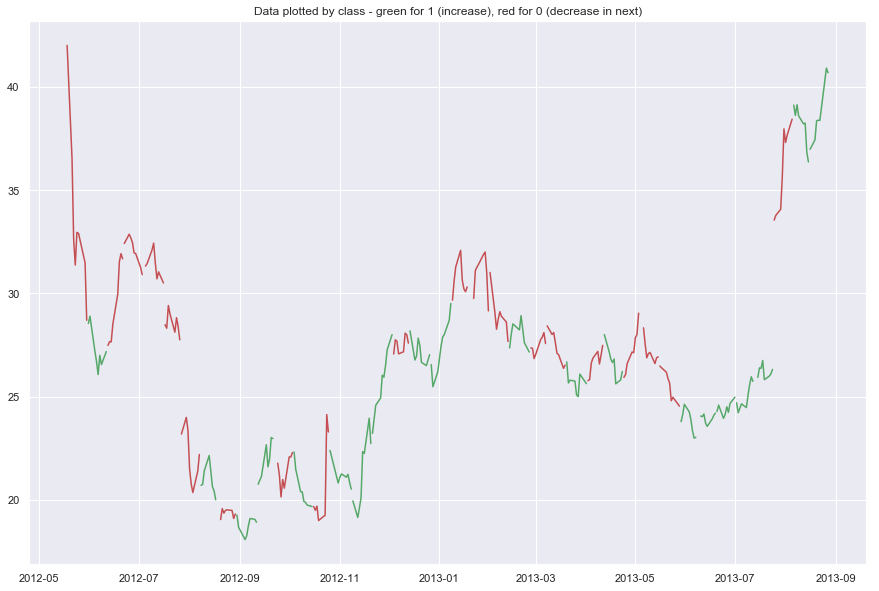

In [250]:
plt.figure(figsize=(15,10))
for x in sliced_data[:40]:
    if x.label.iloc[0] == 0:
#         plt.plot(x.date, x.open, 'bo')
        plt.plot(x.date, x.open, 'r')
    else:
#         plt.plot(x.date, x.open, 'ro')
        plt.plot(x.date, x.open, 'g')
    plt.title("Data plotted by class - green for 1 (increase), red for 0 (decrease in next)")
#     plt.legend() # Wait what

### KNN DTW lib fcts

In [143]:
# KNN DTW stuff from other ipynb
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxint * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in xrange(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in xrange(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in xrange(1, M):
            for j in xrange(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in xrange(0, x_s[0] - 1):
                for j in xrange(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in xrange(0, x_s[0]):
                for j in xrange(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print '\r', self,
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

#### Measuring the DTW distance
The DTW distance between two sequences can be calculated using the `_dtw_distance()` method

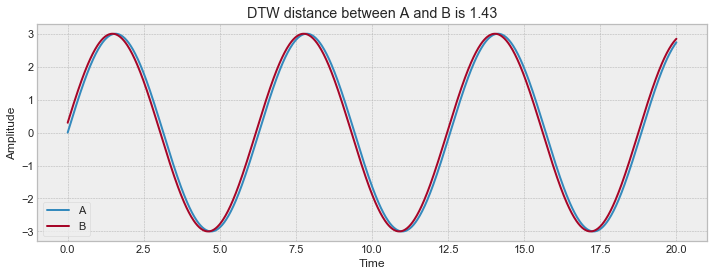

In [148]:
time = np.linspace(0,20,1000)
amplitude_a = 3*np.sin(time)
amplitude_b = 3*np.sin(time + .1)

m = KnnDtw()
distance = m._dtw_distance(amplitude_a, amplitude_b)

fig = plt.figure(figsize=(12,4))
_ = plt.plot(time, amplitude_a, label='A')
_ = plt.plot(time, amplitude_b, label='B')
_ = plt.title('DTW distance between A and B is %.2f' % distance)
_ = plt.ylabel('Amplitude')
_ = plt.xlabel('Time')
_ = plt.legend()

### Visualize sample observations from the data 

In [ ]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for i, r in enumerate([0,27,65,100,114,140]):
    plt.subplot(3,2,i+1)
    plt.plot(train_set[r].open, label=labels[y_train[r]], color=colors[i], linewidth=2)
    plt.xlabel('Samples @50Hz')
    plt.legend(loc='upper left')
    plt.tight_layout()